In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml
import wandb

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/wandb/util.py:35: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence


In [3]:
predictions_dict = {}

In [4]:
config_filename = 'default.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [5]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_06012021_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 213                 | 214                 | 215                 | 216                 | 217                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-28 00:00:00 | 2020-10-29 00:00:00 | 2020-10-30 00:00:00 | 2020-10-31 00:00:00 | 2020-11-01 00:00:00 |
| state       | Delhi               | Delhi               | Delhi               | Delhi               | Delhi               |
| district    | Delhi               | Delhi               | Delhi               | Delhi               | Delhi               |
| total       | 370657.43           | 375759.43           | 381644.0            | 386706.0            | 392370.0   

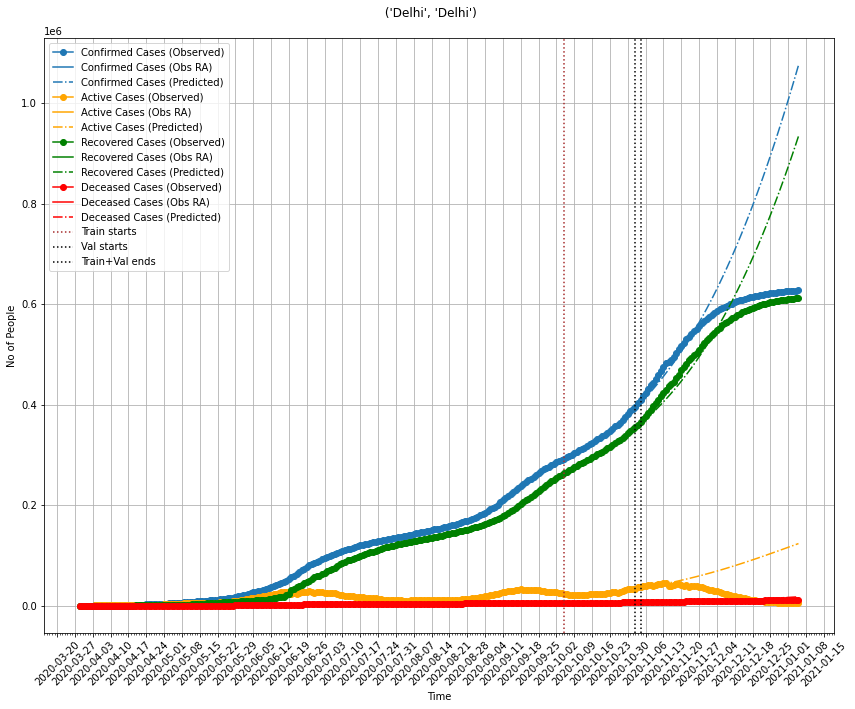

In [6]:
%%time
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting']))

Performing m2 fit ..
loading from ../../misc/cache/dataframes_ts_06012021_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 216                 | 217                 | 218                 | 219                 | 220                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-31 00:00:00 | 2020-11-01 00:00:00 | 2020-11-02 00:00:00 | 2020-11-03 00:00:00 | 2020-11-04 00:00:00 |
| state       | Delhi               | Delhi               | Delhi               | Delhi               | Delhi               |
| district    | Delhi               | Delhi               | Delhi               | Delhi               | Delhi               |
| total       | 386564.86           | 392268.29           | 396371.0            | 403096.0            | 409938.0   

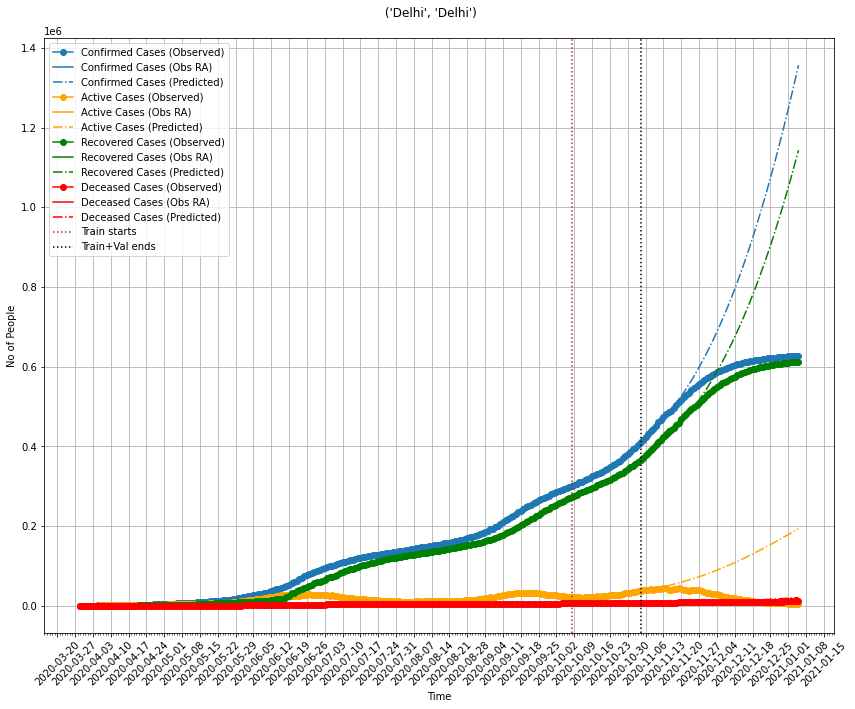

In [7]:
m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = timestamp.strftime("%Y-%m-%d")

In [8]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.6500043841529072,
 'I_hosp_ratio': 0.2389488518203803,
 'P_fatal': 0.02408103657280937,
 'T_inc': 4.189807112646629,
 'T_inf': 3.7143857434820844,
 'T_recov': 7.502943993587431,
 'T_recov_fatal': 24.244001938432536,
 'lockdown_R0': 1.252330435334518}

In [9]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.2711266991483359,
 'I_hosp_ratio': 0.6199541192347964,
 'P_fatal': 0.02646693324677804,
 'T_inc': 4.952486963304518,
 'T_inf': 3.334787082197154,
 'T_recov': 7.404999633098776,
 'T_recov_fatal': 30.87099134024356,
 'lockdown_R0': 1.3403357306340198}

## Loss Dataframes

### M1 Loss DataFrame

In [10]:
predictions_dict['m1']['df_loss']

,train,val,test
total,0.352207,1.22806,2.41491
active,2.54263,5.07404,16.1776
recovered,0.315175,0.923779,3.65838
deceased,0.995377,3.45045,3.94258


### M2 Loss DataFrame

In [11]:
predictions_dict['m2']['df_loss']

,train,test
total,0.475974,1.86393
active,3.26006,27.5281
recovered,0.349545,1.81186
deceased,0.911633,2.59642


## Sensitivity Plot

100%|██████████| 101/101 [00:01<00:00, 80.88it/s]


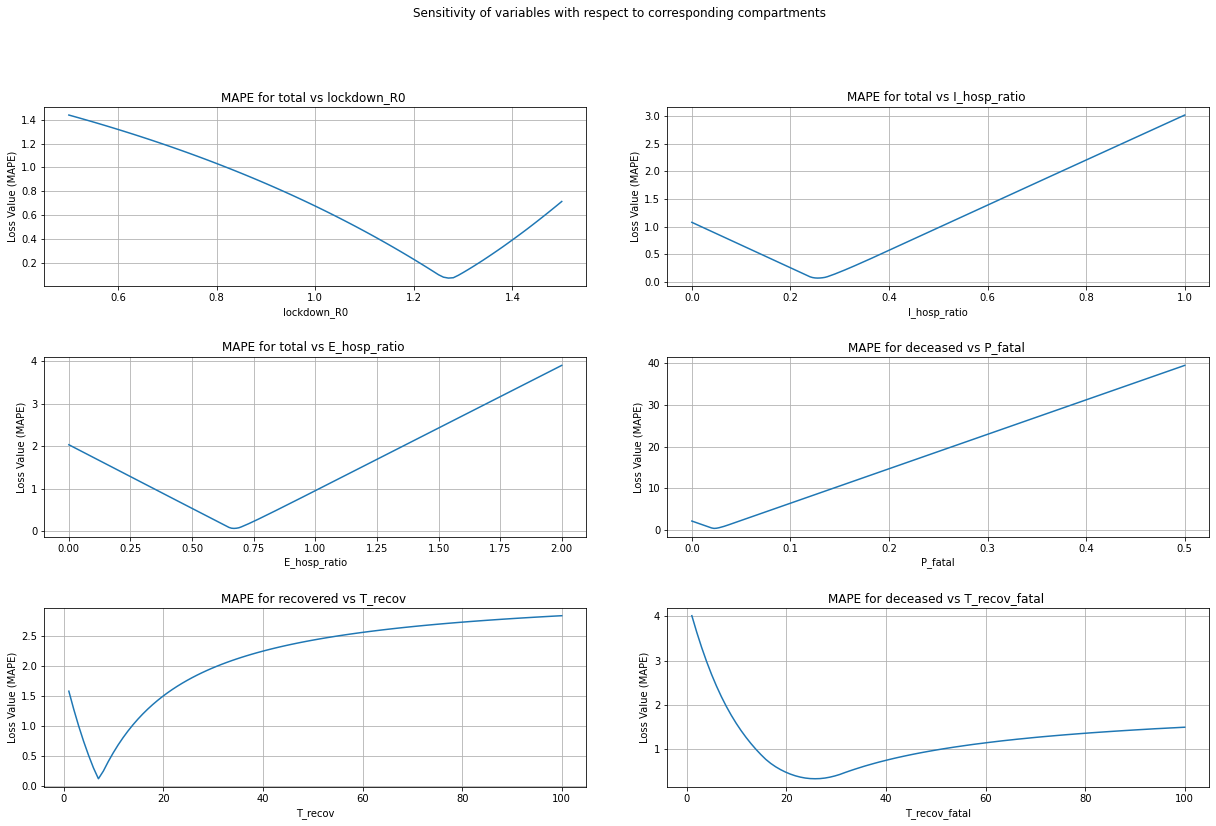

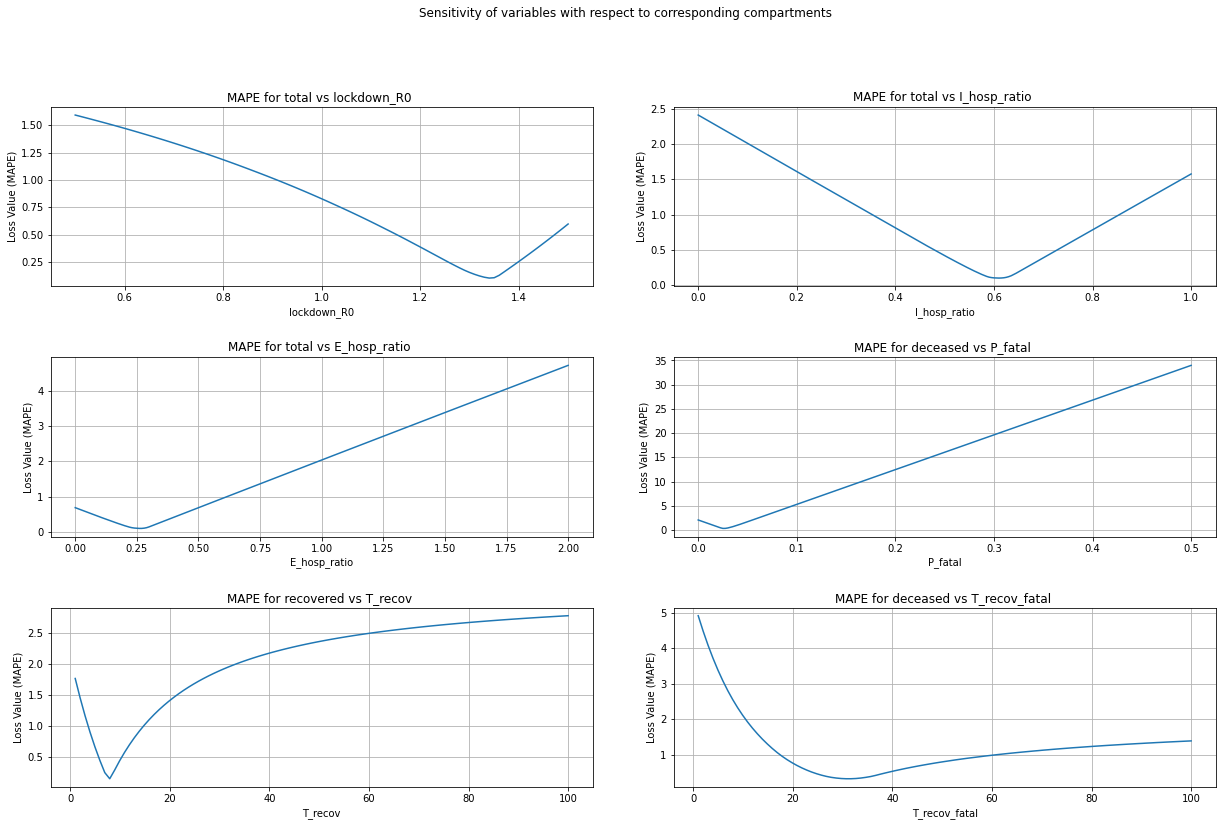

In [12]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

0it [00:00, ?it/s]getting forecasts ..
getting forecasts ..
2000it [00:28, 69.45it/s]
10it [00:00, 96.19it/s]getting forecasts ..
2000it [00:23, 86.40it/s]


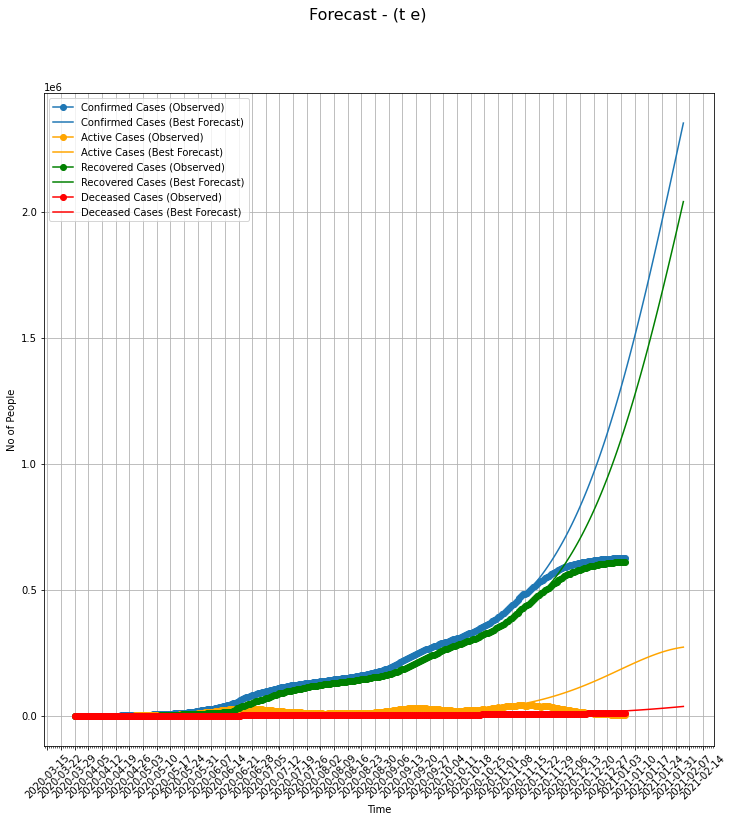

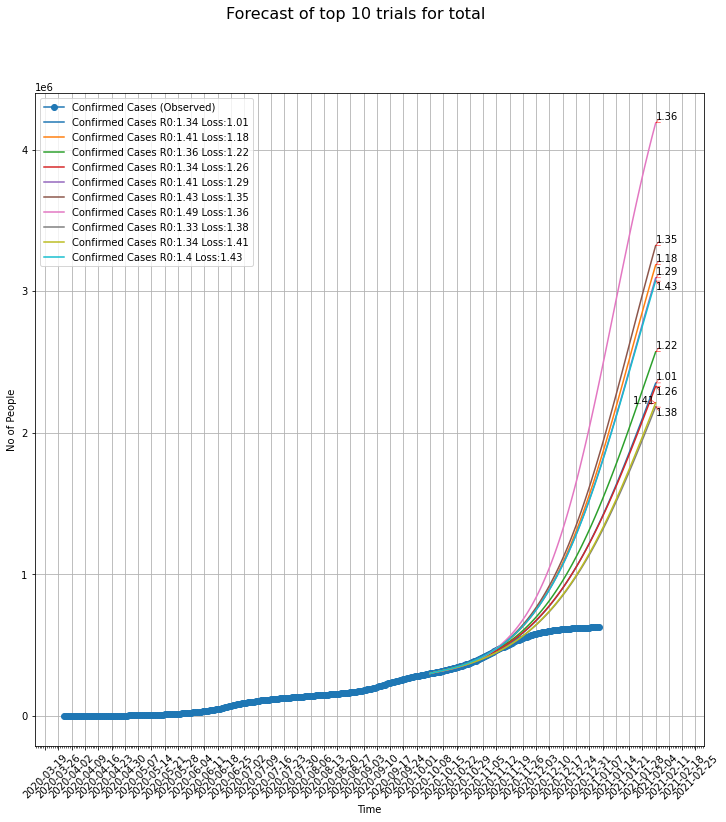

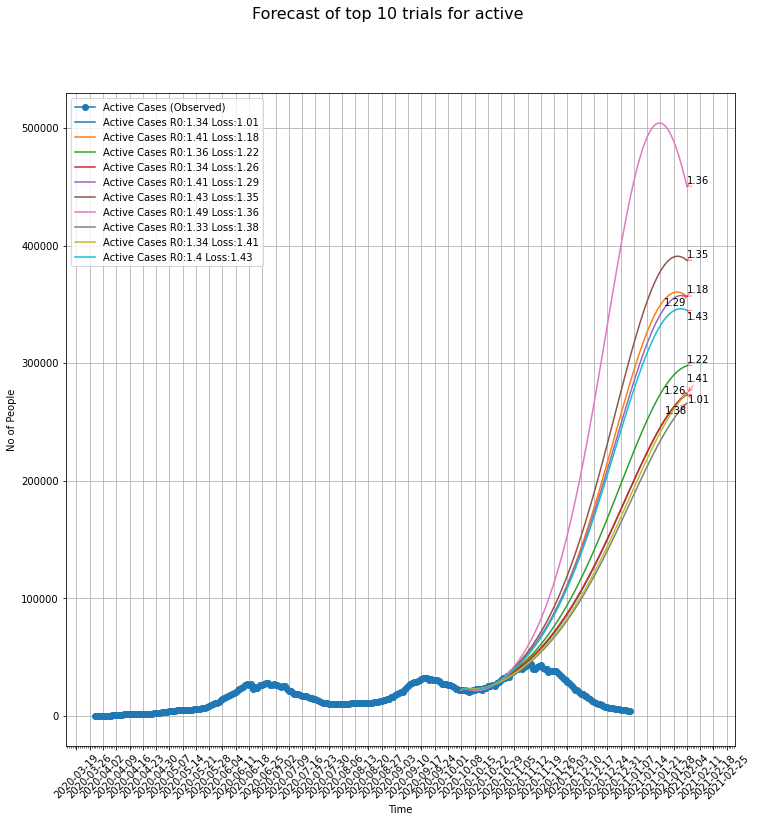

In [13]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 'test', 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [14]:
config = read_config(config_filename)

In [15]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
                    
uncertainty = config['uncertainty']['method'](**uncertainty_args)

9it [00:00, 81.80it/s]getting forecasts ..
2000it [00:23, 86.56it/s]
100%|██████████| 101/101 [02:43<00:00,  1.61s/it]
Best beta - 4.6000000000000005
Min Loss - 2.6229400799178504


In [16]:
uncertainty.ensemble_mean_forecast['df_loss']

{'active': 16.044549610540184,
 'recovered': 3.6174418966405724,
 'deceased': 2.7740469879917917,
 'total': 2.451980038761396}

In [17]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [ ]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

In [ ]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 48.7804878], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80.48780488], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 48.7804878], error_bars=False)

In [1]:
config['forecast']['plot_ptiles_for_columns']

UsageError: Invalid config statement: "['forecast']['plot_ptiles_for_columns']", should be `Class.trait = value`.


In [2]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

NameError: name 'plot_ptiles' is not defined

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on MLFlow

In [1]:
a = {1:[2,3],2:[3,4],3:[4,5]}
b = {1:[4,5],2:[5,6],3:[7,8]}

In [2]:
a.update(b)

In [3]:
a


{1: [4, 5], 2: [5, 6], 3: [7, 8]}

In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)